# Importing Modules

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from numpy import random
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import statsmodels.api as sm 
from numpy import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from random import randint
from itertools import chain
from sklearn import metrics

# Essential Functions

In [605]:
##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

#Function to simulate fault
def simulateFault(sensedValues,params):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index/4
    BMS = []
    classification = []
    
    noise = random.rand(len(sensedValues)) * params['err']
    for i in range(0, len(sensedValues)):
        if i <= interval:
            a = params['constant']
            sign = random.randint(1,3)
            print('goes here')
            if sign == 1:
                BMS.append(noise[i] + a + sensedValues[i])
            else:
                BMS.append(-noise[i] + a + sensedValues[i])
            classification.append(1)

        elif i > interval and i <= interval*2:
            B = params['coeff']
            sign = random.randint(1,3)
            #print('goes here1')
            if sign == 1:
                BMS.append(noise[i] + B * sensedValues[i])
            else:
                BMS.append(noise[i] + B * sensedValues[i])
            classification.append(1)

        elif i > interval*2 and i<= interval*3:
            a = params['stuck']
            #print('goes here2')
            BMS.append(a)
            classification.append(1)
            
        elif i > interval*3 and i<= interval*4:
            #print('goes here3')
            type_fault = random.randint(1,3)
            low_bound = params['bounds'][0]
            up_bound = params['bounds'][1]
            if type_fault == 1:
                BMS.append(low_bound-noise[i])
            else:
                BMS.append(up_bound + noise[i])
            classification.append(1)
        else:
            #print('goes here4')
            BMS.append(noise[i] + sensedValues[i])
            classification.append(0)

    BMS = np.array(BMS)
    BMS = BMS.round(decimals = 3)
    sensedValues = sensedValues.round(decimals=3)
    return np.array(BMS), np.array(classification)

def simulateSpecificFault(sensedValues, params, value):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index
    BMS = []
    classification = []
    
    #noise = random.rand(len(sensedValues)) * 0
    
    for i in range(0, len(sensedValues)):
        if i < interval:
            if params == 'constant':
                a = value
                #sign = random.randint(1,3)
                #print('goes here')
                #if sign == 1:
                BMS.append(a + sensedValues[i])
                #else:
                #    BMS.append(noise[i] - a + sensedValues[i])
                classification.append(1)

            elif params == 'gain':
                B = value 
                sign = random.randint(1,3)
                if sign == 1:
                    BMS.append(B * sensedValues[i])
                else:
                    BMS.append(B * sensedValues[i])
                classification.append(1)

            elif params == 'stuck':
                a = value
                BMS.append(a)
                classification.append(1)
            
            elif params == 'bounds':
                half_point = interval/2
                if i < half_point:
                    x = random.randint(273, 289)
                    BMS.append(x)
                else:
                    x = random.randint(303, 323)
                    BMS.append(x)
                classification.append(1)
        else:
            BMS.append(sensedValues[i])
            classification.append(0)

    BMS = np.array(BMS)
    BMS = BMS.round(decimals = 3)
    sensedValues = sensedValues.round(decimals=3)
    return np.array(BMS), np.array(classification)

#Function to generate noise
def generateNoise(noise, values):
    noisy_data = []
    for i in range(0,len(values)):
        noisy_data.append(values[i]+random.uniform(-noise,noise))
    return noisy_data

#Function to define vectors for regression model
def define_vectors(vals):
    x1 = []
    x2 = []
    x = []
    y = []
    for i in range(1,len(vals)):
        lhs_term1 = 20.52*240*(vals['zone_temp'][i]-vals['zone_temp'][i-1])/300
        lhs_term2 = 1005*(vals['supply_temp'][i]-vals['zone_temp'][i])*vals['air_flow'][i]
        lhs_term3 = 100 * vals['occupancy'][i]
        c = lhs_term1 - lhs_term2 - lhs_term3
        y.append(c)
        #x1.append(100)
        x2.append((vals['outdoor_temp'][i]-vals['zone_temp'][i]))
    inputs = {'x2':x2}
    output = {'y':y}
    return inputs, output

def perform_classification(err, bounds):
    
    j = 0
    
    while j <= err:
        
        true_fault = []

        for i in range(0,len(bounds)):
            if bounds['zone_temp'][i] > (bounds['pred'][i] + j) or bounds['zone_temp'][i] < (bounds['pred'][i] - j):
                true_fault.append(1)
            else:
                true_fault.append(0)
                
        bounds['predClass'] = true_fault
        
        j = j + 0.1
                
    bounds['predClass'] = true_fault
    
    return bounds

def compute_TPR_FPR(err, bounds, temporal_difference):
    tpr = []
    fpr = []
    j = 0
    while j <= err*12:
        
        true_fault = []

        for i in range(0,len(bounds)):
            if bounds['zone_temp'][i] > (bounds['pred'][i] + j) or bounds['zone_temp'][i] < (bounds['pred'][i] - j):
                true_fault.append(1)
            else:
                if bounds['lag_1'][i] == bounds['lag_2'][i] and bounds['lag_1'][i] == bounds['lag_3'][i]:
                    true_fault.append(1)
                else:
                    true_fault.append(0)
        bounds['predClass'] = true_fault

        fp = np.sum((bounds['predClass'] == 1) & (bounds['classification'] == 0))
        tp = np.sum((bounds['predClass'] == 1) & (bounds['classification'] == 1))

        fn = np.sum((bounds['predClass'] == 0) & (bounds['classification'] == 1))
        tn = np.sum((bounds['predClass'] == 0) & (bounds['classification'] == 0))

        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
        j = j + 1
    
    return tpr, fpr

def prepare_temporal_difference_vector(vector):
    
    vector['lag_1'] = vector['zone_temp'].shift(1)
    vector['lag_2'] = vector['zone_temp'].shift(2)
    vector['lag_3'] = vector['zone_temp'].shift(3)
    
    vector = vector[['lag_1', 'lag_2', 'lag_3']]
    vector = vector.dropna()
    
    print(vector)
    return vector

def calculate_zone_temp(resistance, thermal, vals):
    
    pred_array = []
    true_array = []

    for i in range(1,len(vals)):
        result = 0
        
        rhs = 16.42 * vals['zone_temp'][i-1] + 1005 * vals['supply_temp'][i]*vals['air_flow'][i] +100 *(vals['occupancy'][i]+thermal) + resistance * vals['outdoor_temp'][i]
        lhs = 16.42 + 1005*vals['air_flow'][i] + resistance
        result = rhs/lhs

        pred_array.append(result)
        true_array.append(vals['zone_temp'][i])
    
    return pred_array, true_array

def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

# Initializing dataset

In [494]:
data = pd.read_csv('data/result.csv',parse_dates=['time'], index_col=['time'])
data['outdoor_temp'] = data['outdoor_temp'] + 273
data['zone_temp'] = data['zone_temp'] + 273
data['supply_temp'] = data['supply_temp'] + 273

# Initializing Training and Validation dataset

In [625]:
train = data[0:int(len(data)*0.8)] #data[53086:53089]
inputs, output = define_vectors(train)

inputs = pd.DataFrame(data = inputs)
output = pd.DataFrame(data = output)

errType = 'constant'

##Code for feedback in the loop for data quality
# (T_z - T_z_n-1)/300
# stats = inputs.describe()
# init_std = 0#stats['x2']['std']
# end_index = 53090

# #Collect data till the overall dataset meets the desired std
# while True:
#     train = data[53086:end_index]
#     inputs, output = define_vectors(train)
    
#     inputs = pd.DataFrame(data = inputs)
#     output = pd.DataFrame(data = output)
    
#     stats = inputs.describe()
#     temp_std = stats['x2']['std']
    
#     if init_std < temp_std and len(inputs) >= 2 and len(inputs) <= 12:
#         init_std = temp_std
#         end_index = end_index + 1
    
#     else:
#         break
        
# #The n-1th index of the dataset has the best overall std
# train = data[53084:end_index-1]
# print(train)
# #train['zone_temp'],train_label = simulateSpecificFault(train['zone_temp'], 'constant', 0)
# #print(train)
# inputs, output = define_vectors(train)

# inputs = pd.DataFrame(data = inputs)
# output = pd.DataFrame(data = output)

test = data[int(len(data)*0.8):] #data[end_index-1:end_index + 10]
test = test.reset_index()
test['supply_temp'],test_label = simulateSpecificFault(test['supply_temp'], errType, 15)
#test_label = test_label[3:]
print(test)
print(len(test_label))
inputs_test, output_test = define_vectors(test)
temporal_difference = prepare_temporal_difference_vector(test)
temporal_difference = temporal_difference.reset_index()

inputs_test = pd.DataFrame(data = inputs_test)
output_test = pd.DataFrame(data = output_test)
print(inputs_test)

                     time  outdoor_temp   zone_temp  occupancy  supply_temp  \
0     2017-10-20 00:00:00    284.000000  296.506852          0      313.000   
1     2017-10-20 00:05:00    283.833333  296.542210          0      313.000   
2     2017-10-20 00:10:00    283.666667  296.574347          0      313.000   
3     2017-10-20 00:15:00    283.500000  296.358471          0      312.387   
4     2017-10-20 00:20:00    283.333333  296.376791          0      313.000   
...                   ...           ...         ...        ...          ...   
21020 2017-12-31 23:40:00    279.000000  295.990503          0      298.000   
21021 2017-12-31 23:45:00    279.000000  295.988552          0      298.000   
21022 2017-12-31 23:50:00    279.000000  295.986715          0      298.000   
21023 2017-12-31 23:55:00    279.000000  295.984990          0      298.000   
21024 2018-01-01 00:00:00    279.000000  295.983374          0      298.000   

       air_flow  
0      0.733767  
1      0.733767

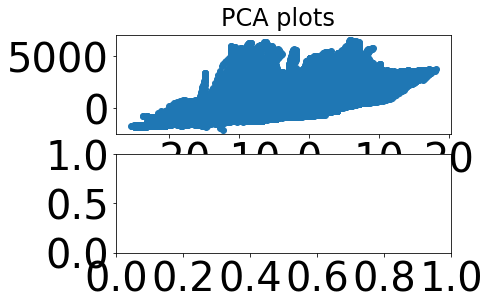

In [626]:
fig, axs = plt.subplots(2)
plt.rcParams.update({'font.size': 20})
fig.suptitle('PCA plots')
#axs[0].scatter(inputs['x1'], output['y'])
axs[0].scatter(inputs['x2'], output['y'])
plt.show()

In [627]:
scaler = StandardScaler()
scaler1 = StandardScaler()
inputs_scaled = scaler.fit_transform(inputs)
output_scaled = scaler1.fit_transform(output)
inputs_test_scaled = scaler.transform(inputs_test)

[[-1.92970739]
 [-1.97353968]
 [-2.01712623]
 ...
 [-0.8773949 ]
 [-0.8866081 ]
 [-0.89582893]]


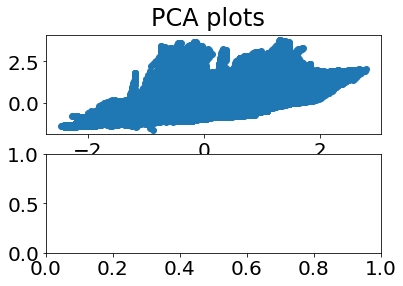

In [628]:
print(inputs_scaled)
fig, axs = plt.subplots(2)
plt.rcParams.update({'font.size': 20})
fig.suptitle('PCA plots')
#axs[0].scatter(inputs['x1'], output['y'])
axs[0].scatter(inputs_scaled, output_scaled)
plt.show()

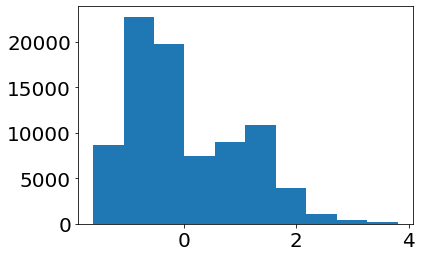

In [629]:
plt.hist(output_scaled)
plt.show()

# Using OLS regression for fault detection

In [630]:
inputs_with_constant = sm.add_constant(inputs)
model = sm.OLS(output_scaled,inputs_with_constant)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 1.137e+05
Date:                Fri, 02 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:03:04   Log-Likelihood:                -83369.
No. Observations:               84095   AIC:                         1.667e+05
Df Residuals:                   84093   BIC:                         1.668e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4579      0.003    174.293      0.000       0.453       0.463
x2             0.0915      0.000    337.149      0.000       0.091       0.092
==============================================================================
Omnibus:                    25970.526   Durbin-Watson:                   0.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96514.493
Skew:                           1.523   Prob(JB):                         0.00
Kurtosis:                       7.273   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [631]:
results.params['const']

0.4578559521899488

# Using SVR model for fault detection

In [324]:
regr = SVR(kernel = 'linear')
regr.fit(inputs_scaled, output_scaled)

/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [632]:
pred_array, true_array = calculate_zone_temp(results.params['x2'],results.params['const'],train)
# pred_array = list(chain.from_iterable(pred_array))
# pred_array = list(chain.from_iterable(pred_array))
print(pred_array[500:505])
print(true_array[500:505])
err = np.sqrt(mse(true_array, pred_array))
print(err)

[295.796248949691, 295.7632973417168, 295.7312423225351, 295.6999101424322, 296.1276772298497]
[295.9223218, 295.87364835, 295.82630291, 295.77983029, 295.79744067]
2.291947846517265


In [633]:
pred_array, true_array = calculate_zone_temp(results.params['x2'],results.params['const'],test)
print(pred_array[0:5])
print(true_array[0:5])

[312.6979896089855, 312.6987394339817, 312.0220827973371, 312.6946973849156, 312.69507614469904]
[296.54221012, 296.57434733, 296.35847078, 296.37679051, 296.478489]


# Compute TPR and FPR for ROC curve

In [634]:
upper_bound = []
lower_bound = []

upper_bound = pred_array 
lower_bound = pred_array 
bounds = test[1:]
bounds = bounds.reset_index()
bounds['upper'] = upper_bound + err
bounds['lower'] = lower_bound - err
bounds['pred'] = pred_array
bounds['classification'] = test_label[1:]
bounds = bounds.dropna()
bounds = bounds.reset_index()
bounds

,level_0,index,time,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow,lag_1,lag_2,lag_3,upper,lower,pred,classification
0,2,3,2017-10-20 00:15:00,283.500000,296.358471,0,312.387,0.573906,296.574347,296.542210,296.506852,314.314031,309.730135,312.022083,1
1,3,4,2017-10-20 00:20:00,283.333333,296.376791,0,313.000,0.733767,296.358471,296.574347,296.542210,314.986645,310.402750,312.694697,1
2,4,5,2017-10-20 00:25:00,283.166667,296.478489,0,313.000,0.733767,296.376791,296.358471,296.574347,314.987024,310.403128,312.695076,1
3,5,6,2017-10-20 00:30:00,283.000000,296.539936,0,313.000,0.733767,296.478489,296.376791,296.358471,314.989219,310.405323,312.697271,1
4,6,7,2017-10-20 00:35:00,282.833333,296.308848,0,312.354,0.585523,296.539936,296.478489,296.376791,314.287939,309.704044,311.995992,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21017,21019,21020,2017-12-31 23:40:00,279.000000,295.990503,0,298.000,0.733767,295.992560,295.994725,295.997031,300.306651,295.722755,298.014703,0
21018,21020,21021,2017-12-31 23:45:00,279.000000,295.988552,0,298.000,0.733767,295.990503,295.992560,295.994725,300.306606,295.722711,298.014658,0
21019,21021,21022,2017-12-31 23:50:00,279.000000,295.986715,0,298.000,0.733767,295.988552,295.990503,295.992560,300.306564,295.722668,298.014616,0
21020,21022,21023,2017-12-31 23:55:00,279.000000,295.984990,0,298.000,0.733767,295.986715,295.988552,295.990503,300.306524,295.722628,298.014576,0


In [621]:
tpr, fpr = compute_TPR_FPR(err, bounds, temporal_difference)

# Generating ROC curve figure

<Figure size 432x288 with 0 Axes>

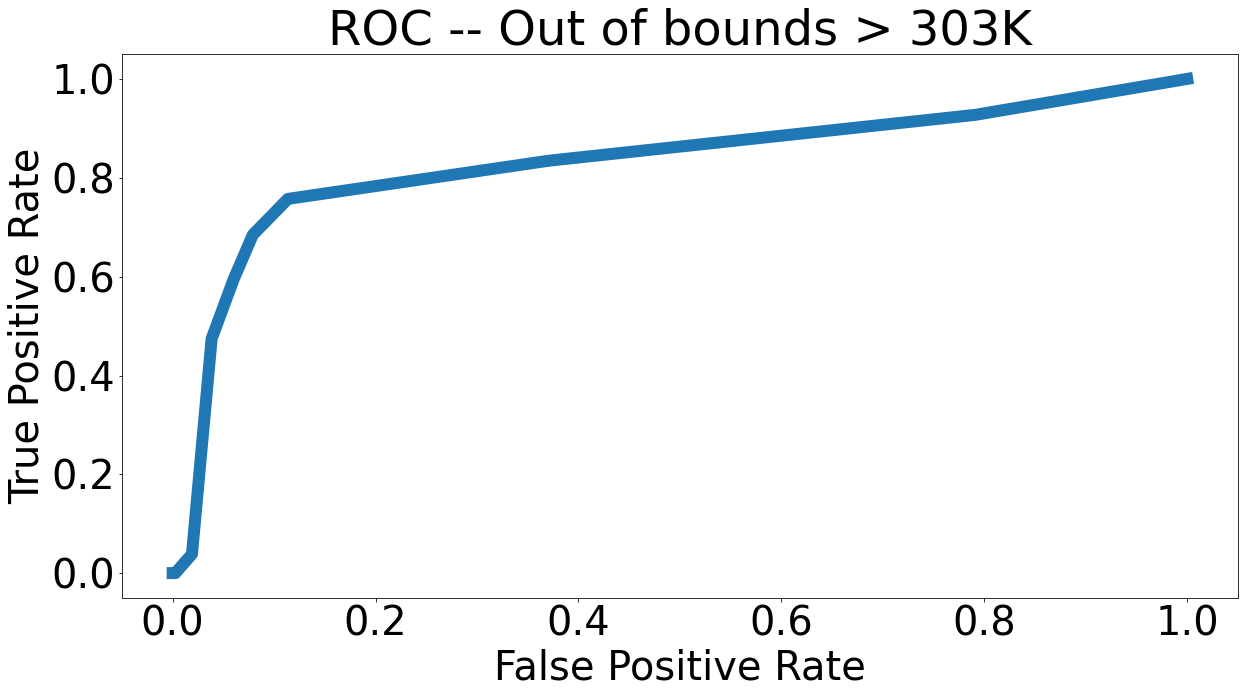

In [622]:
plt.figure()
plt.rcParams.update({'font.size': 40})
plt.figure(figsize=(20,10))
plt.plot(fpr, tpr, linewidth = 12)
plt.xticks(np.arange(0, 1.1, step=0.2))
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC -- Out of bounds > 303K')
plt.show()

# Fault classification visual (Note: Better used when test data is small)

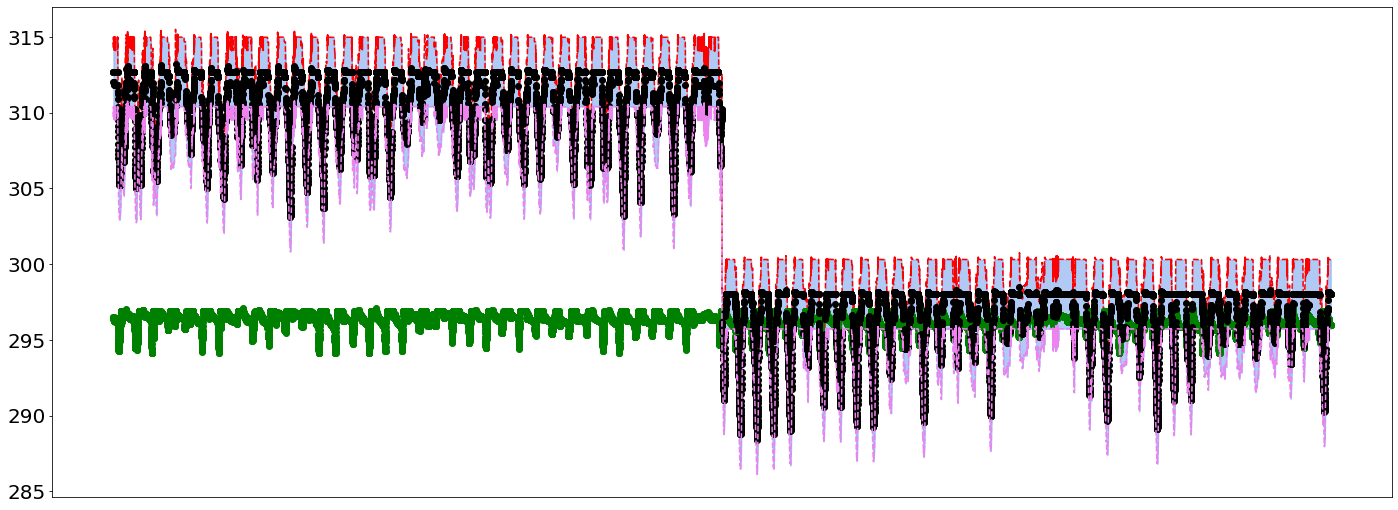

In [635]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%D:%H:%M:%S')

ax.plot(bounds.index, bounds['upper'].values, '--', color = 'red', label = 'Upper bound')
ax.plot(bounds.index, bounds['zone_temp'].values, 'o', color = 'green', label = 'Actual')
ax.plot(bounds.index, bounds['pred'].values, 'o', color = 'black', label = 'Predicted')
ax.plot(bounds.index, bounds['lower'].values, '--', color = 'violet', label = 'Lower Bound')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(24, 10)
plt.fill_between(bounds.index, bounds['upper'].values,bounds['lower'].values,color='cornflowerblue',alpha=.5)
plt.show()

# ROC Figure generation script

In [606]:
errType = 'bounds'
value = 290
tpr_list = []
fpr_list = []

for i in range(0,1):
    
    #load data and preprocess it 
    
    train = data[0:int(len(data)*0.8)] 
    inputs, output = define_vectors(train)

    inputs = pd.DataFrame(data = inputs)
    output = pd.DataFrame(data = output)

    test = data[int(len(data)*0.8):] 
    test = test.reset_index()
    test['supply_temp'],test_label = simulateSpecificFault(test['supply_temp'], errType, value)
    inputs_test, output_test = define_vectors(test)
    temporal_difference = prepare_temporal_difference_vector(test)
    temporal_difference = temporal_difference.reset_index()

    inputs_test = pd.DataFrame(data = inputs_test)
    output_test = pd.DataFrame(data = output_test)
    
    scaler = StandardScaler()
    scaler1 = StandardScaler()
    inputs_scaled = scaler.fit_transform(inputs)
    output_scaled = scaler1.fit_transform(output)
    inputs_test_scaled = scaler.transform(inputs_test)
    
    inputs_with_constant = sm.add_constant(inputs)
    model = sm.OLS(output_scaled,inputs_with_constant)
    results = model.fit()
    
    pred_array, true_array = calculate_zone_temp(results.params['x2'],results.params['const'],train)
    err = np.sqrt(mse(true_array, pred_array))
    pred_array, true_array = calculate_zone_temp(results.params['x2'],results.params['const'],test)
    
    upper_bound = []
    lower_bound = []

    upper_bound = pred_array 
    lower_bound = pred_array 
    bounds = test[1:]
    bounds = bounds.reset_index()
    bounds['upper'] = upper_bound + err
    bounds['lower'] = lower_bound - err
    bounds['pred'] = pred_array
    bounds['classification'] = test_label[1:]
    bounds = bounds.dropna()
    bounds = bounds.reset_index()
    
    tpr, fpr = compute_TPR_FPR(err, bounds, temporal_difference)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    
    value = value + 5

            lag_1       lag_2       lag_3
3      296.574347  296.542210  296.506852
4      296.358471  296.574347  296.542210
5      296.376791  296.358471  296.574347
6      296.478489  296.376791  296.358471
7      296.539936  296.478489  296.376791
...           ...         ...         ...
21020  295.992560  295.994725  295.997031
21021  295.990503  295.992560  295.994725
21022  295.988552  295.990503  295.992560
21023  295.986715  295.988552  295.990503
21024  295.984990  295.986715  295.988552

[21022 rows x 3 columns]


<Figure size 432x288 with 0 Axes>

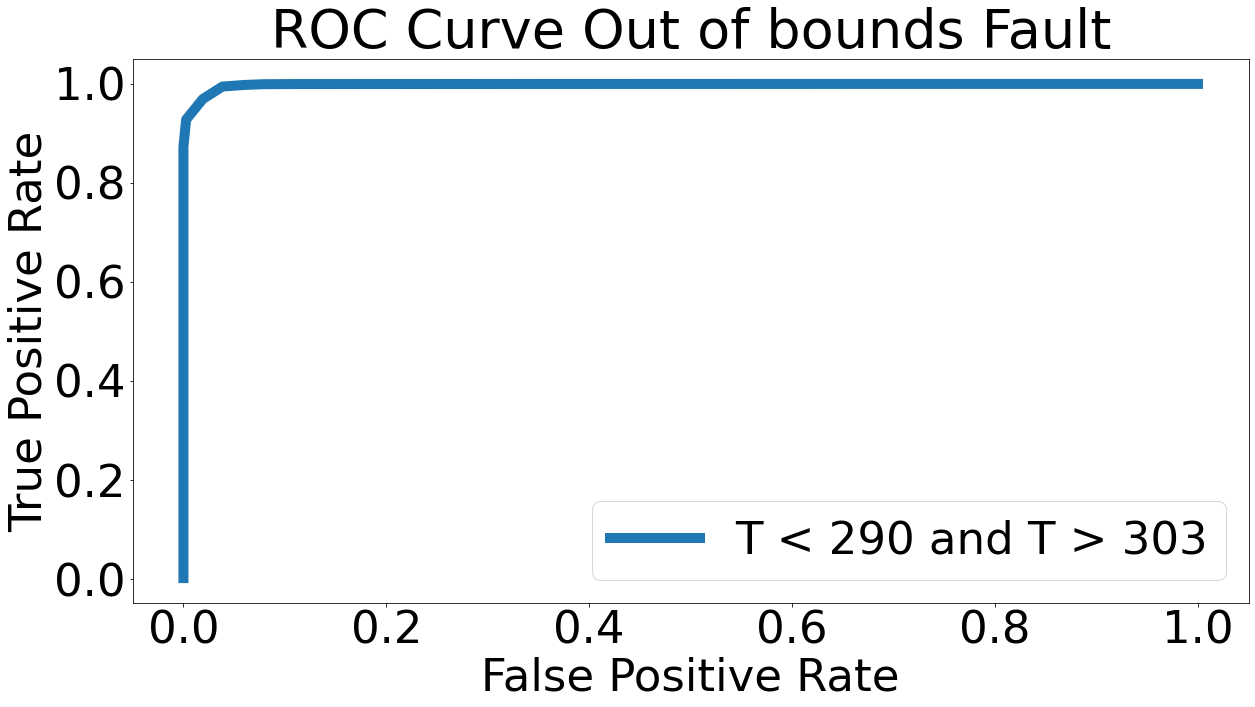

In [610]:
plt.figure()
plt.rcParams.update({'font.size': 45})
plt.figure(figsize=(20,10))
plt.plot(fpr_list[0], tpr_list[0], linewidth = 10, label = "T < 290 and T > 303")
#plt.plot(fpr_list[1], tpr_list[1], linewidth = 10, label = "4%")
#plt.plot(fpr_list[2], tpr_list[2], linewidth = 10, label = "5%")
plt.xticks(np.arange(0, 1.1, step=0.2))
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Out of bounds Fault')
plt.legend(loc="lower right")
plt.show()